# Automatic differentiation with JUDI

In this tutorial, we will look at the automatic differentiation in julia, and in particular how [ChainRules.jl](https://github.com/JuliaDiff/ChainRules.jl) supports addition of your own differentiation rules into Julia's [Automatic Differentiation](https://juliadiff.org) system. This allows for seamless integration between your code, including its handcoded derivatives, and Julia's native AD systems, e.g. those used by [Flux](https://fluxml.ai/Flux.jl/stable/) Julia's machine learning platform. We use [ChainRules.jl](https://github.com/JuliaDiff/ChainRules.jl) to automatically differentiate codes that involve complex operations implemented by [JUDI.jl](https://github.com/slimgroup/JUDI.jl) (this example) and [JOLI.jl](https://github.com/slimgroup/JOLI.jl).

## Introduction to chain rules

We first provide a brief introduction to automatic differentiation and to `rrule`, the [ChainRules.jl](https://github.com/JuliaDiff/ChainRules.jl) interface used to define custom AD rules. With this rules defined, we show how we can use generic AD frameworks (Zygote/Flux in this tutorial) to compute gradients of complicated expression swaping in our own rule for part of the expression.

In [29]:
using Flux, ChainRulesCore, LinearAlgebra, JOLI

### Simple example

Let's consider a simple example with a basic differentiable function $x -> cos(x) + 1$

In [2]:
mycos(x) = cos(x) + 1

mycos (generic function with 1 method)

Now we know that the derivative of this function is $x -> -sin(x)$ from standard functional analysis.e can therefore define through chainrules a new rule for our function `f`

In [3]:
function ChainRulesCore.rrule(::typeof(mycos), x)
    println("Using custom AD rule for mycos")
    y = mycos(x)
    pullback(Δy) = (NoTangent(), -sin(x)*Δy)
    return y, pullback
end

We now have the rule to compute the directional derivative of our function `mycos` . Let's check the gradient

In [4]:
x0 = randn()
# Standard AD of cos
g1 = gradient(x->norm(cos(x)+1)^2, x0);
# Our definition
g2 = gradient(x->norm(mycos(x))^2, x0);
# Analytical gradient
g3 = -2*sin(x0)*(mycos(x0));
println("True gradient: $(g3) \nStandard AD  : $(g1[1]) \nCustom AD    : $(g2[1])")

Using custom AD rule for mycos
True gradient: -1.1650215811256202 
Standard AD  : -1.1650215811256202 
Custom AD    : -1.1650215811256202


And we see that we get the correct gradient. Now this is an extremely simple case, now let's look at a more complicated case where we define the AD rule for matrix-free operators defined in JOLI.

### JOLI

We look at how we define automatic differentiation rules involding matrix-free linear operator. We consider operations of the form `A*x` where `A` is a JOLI matrix-free linear operator and we differentiate with respect to the input `x`

In JOLI, the base type of our linear operator is `joAbstractLinearOperator`. If we define the rule for this abstract type, all linear operator should follow. Now in this case the acual operation to be differentiated is the multiplication `*` with two inputs (`A, x`). Because we consider `A` to be fixed,its derivative will be defined as `NoTangent` that is `ChainRules`'s way to state there is no derivative for this input.

<div class="alert alert-block alert-info"> 
    <b>NOTE</b>
    These rules are implemented inside JOLI and are merely implemented here as an illustration. JOLI operators are usable with FLux/Zygote by default and with any Julia ML framework implemented AD through ChainRules.jl
</div>

In [5]:
using JOLI

In [6]:
function ChainRulesCore.rrule(::typeof(*), A::T, x) where {T<:joAbstractLinearOperator}
    y = A*x
    pullback(Δy) = (NoTangent(), NoTangent(), A'*Δy)
    return y, pullback
end

With this rule defined we can now use a JOLI operator. Let's solve a simple data fitting problem with a restricted Fourier measuerment


In [7]:
using Random
N = 128
# Fourier transform as a linear operator
F = joDFT(N)
# Restriction
R = joRomberg(N; DDT=Complex{Float64}, RDT=Complex{Float64})
# Combine the operators
A = R*F;

In [8]:
# Make data
x = randn(128)
b = A*x;

Let's create a loss function

In [9]:
loss(x) = .5f0*norm(A*x - b)^2 + .5f0*norm(x, 2)^2

loss (generic function with 1 method)

We can now easily obtain the gradient at any given `x` since the only undefined part would have been the JOLI operator that now has its own differentiation rule

In [10]:
x0 = randn(128)
g_ad = gradient(loss, x0)

([3.202332642059349, 3.3474396077773836, 1.7192577704407273, 1.091738893925904, 2.99497941149576, 0.033555000810577607, 2.1856165385946493, -1.9623327339375567, 1.6305386659659917, 0.49094575011054564  …  1.498782430471393, 3.979368223594536, 2.37224960018878, -1.7065306486883383, 0.2043370108057428, -1.1826425144324078, 1.76641366139114, -3.0095898127121723, 3.064337151574949, 5.76008767012525],)

Once again, we can compare to the know analytical gradient

In [11]:
g_hand = A'*(A*x0 - b) + x0;
err = norm(g_hand - g_ad[1])

6.845562607034591e-15

And we get the exact gradient without the AD system needing to know what `A` computes but using the prededined rule for `A*x`

### Optimization
Let's now slve the problem above with standard gradient descent

In [12]:
using Optim

In [13]:
δloss!(g, x) = begin g.=gradient(loss, x)[1]; return loss(x) end;

In [14]:
summary = optimize(loss, δloss!, randn(N), ConjugateGradient(),
                   Optim.Options(g_tol = 1e-12, iterations = 200, store_trace = true, show_trace = true, show_every=1))

Iter     Function value   Gradient norm 
     0     2.078016e+02     7.110069e+00
 * time: 0.008176088333129883
     1     2.996845e+01     3.191891e-15
 * time: 0.32667112350463867


 * Status: success

 * Candidate solution
    Final objective value:     2.996845e+01

 * Found with
    Algorithm:     Conjugate Gradient

 * Convergence measures
    |x - x'|               = 3.56e+00 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.52e+00 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.78e+02 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.93e+00 ≰ 0.0e+00
    |g(x)|                 = 3.19e-15 ≤ 1.0e-12

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    1
    f(x) calls:    3
    ∇f(x) calls:   2


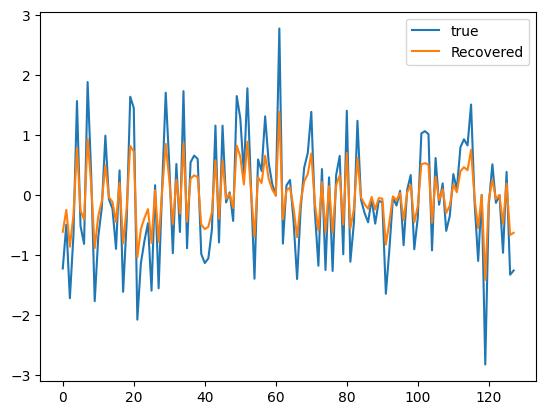

PyObject <matplotlib.legend.Legend object at 0x293c82910>

In [15]:
using PythonPlot
plot(x, label="true")
plot(summary.minimizer, label="Recovered")
legend()

# Automatic differentiation for JUDI

With this introductory example, we have seen how to define simple derivative reverse rules. However, seismic inversion tend to rely and much more complicated operator such as the discrete wave-equation and its non-linear dependence to the velocity. While implementing a pure native-julia propagator using simple artithmetic operations easy to differentiate would be possible, this would limit the control user have on crtitical pieces such as the imaging condition and the memory management for the forward wavefield.  Consequently, most seismic inversion framework a very carefully implemented but do not necessarly allow for plug-and-play with external framework. This incompatibility makes the integration of modern machine learning algorithms extremely complciated, if feasible at all, with these legacy software.


In JUDI, we made design choice from the beginning of high level abstractions and separation of concern that allow easy extension. In the following, we will demonstrate how JUDI can be integrated with machine learning algorithm trivially thanks to the definition of the core rules for adjoint state problem. More specifically, JUDI implements the rule for the following derivatives:

- $\frac{d \mathbf{F} * \mathbf{q}}{d \mathbf{q}}$ where $\mathbf{F} = \mathbf{P}_r \mathbf{A}^{s} \mathbf{P}_s^T$ is a forward ($s=-1$) or adjoint ($s=-*$) propagator. JUDI supports numerous cases including full wavefield modelling ($\mathbf{P}_s=\mathbf{P}_r=\mathcal{I}$, stanrad point source and point receivers, and extendend source modeling. 
- $\frac{d \mathbf{F} * \mathbf{q}}{d \mathbf{m}}$ where $\mathbf{F}$ is a forward ($s=-1$) or adjoint ($s=-*$) propagator. This effectively allow for FWI with any chosen misfit function $\rho_{\mathbf{m}}(\mathbf{F} * \mathbf{q}, \mathbf{q})$
- $\frac{d \mathbf{J} * \mathbf{dm}}{d \mathbf{dm}}$ where $\mathbf{J}$ is the standard FWI/RTM jacobian of the forward operator $\mathbf{F}$
- $\frac{d \mathbf{J}(\mathbf{q}) * \mathbf{dm}}{d \mathbf{q}}$ where once again $\mathbf{J}$ is the standard FWI/RTM jacobian of the forward operator and $\mathbf{q}$ is the source of the forward modeling operator


With all these derivatives predefine, we can easily let the implementation of the propagators and Jacobian handle high performance kernels (via [Devito](https://github.com/devitocodes/devito)), advanced imaging condition and efficient memory mamangement. From these rules, the AD framework will only call the propagation kernels implemented in JUDI and integrate it as part of the chain of differentiation. 


We now illustrate these capabilities on a few trivial example that show the flexibiluty of our inversion framework.


In [16]:
using JUDI, Flux

In [17]:
using SlimPlotting
# Set up model structure
n = (120, 100)   # (x,y,z) or (x,z)
d = (10., 10.)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.4f0
v0 = ones(Float32,n) .+ 0.4f0
v[:, Int(round(end/2)):end] .= 4f0

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2
dm = vec(m - m0);# Lets get some simple default parameter

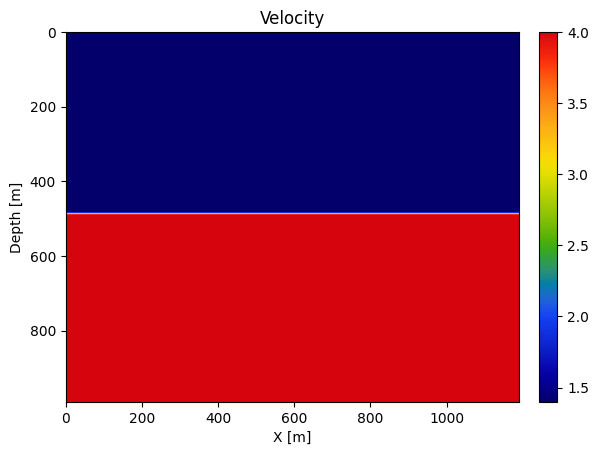

In [18]:
plot_velocity(v', d; cbar=true)

In [19]:
# Setup model structure
nsrc = 1	# number of sources
model0 = Model(n, d, o, m0)

# Set up receiver geometry
nxrec = 120
xrec = range(50f0, stop=1150f0, length=nxrec)
yrec = 0f0
zrec = range(50f0, stop=50f0, length=nxrec)

# receiver sampling and recording time
time = 1000f0   # receiver recording time [ms]
dt = 1f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=nsrc)

## Set up source geometry (cell array with source locations for each shot)
xsrc = convertToCell([600f0])
ysrc = convertToCell([0f0])
zsrc = convertToCell([20f0])

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dt, t=time)

GeometryIC{Float32} wiht 1 sources


In [20]:

# setup wavelet
f0 = 0.01f0     # MHz
wavelet = ricker_wavelet(time, dt, f0)
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 1 sources


### Return type

Whule JUDI defines its own dimensional types, it is recommended to drop the metadata and return pure array/tensors for ML. This can be done with a simple option passed to the propagators

In [21]:
opt = Options(return_array=true)

JUDIOptions(8, false, false, 1000.0f0, false, "", "shot", false, false, Any[], "as", 1, 1, true, nothing, 0.015f0)

In [22]:
F0 = judiModeling(model0, srcGeometry, recGeometry; options=opt)
num_samples = recGeometry.nt[1] * nxrec # Number of value

120120

In [23]:
##################################################################################
# Fully connected neural network with linearized modeling operator
n_in = 100
n_out = 10

W1 = randn(Float32, prod(model0.n), n_in)
b1 = randn(Float32, prod(model0.n))

W2 = judiJacobian(F0, q)
b2 = randn(Float32, num_samples)

W3 = randn(Float32, n_out, num_samples)
b3 = randn(Float32, n_out);


┌ Warning: Deprecated model.n, use size(model)
│   caller = ip:0x0
└ @ Core :-1


In [24]:
function network(x)
    x = W1*x .+ b1
    x = vec(W2*x) .+ b2
    x = W3*x .+ b3
    return x
end

network (generic function with 1 method)

In [25]:
# Inputs and target
x = zeros(Float32, n_in)
y = randn(Float32, n_out);

In [26]:
# Evaluate MSE loss
loss(x, y) = Flux.mse(network(x), y)


loss (generic function with 2 methods)

In [27]:
# Compute gradient w.r.t. x and y
Δx, Δy = gradient(loss, x, y)


Building born operator
Operator `born` ran in 0.04 s
Building forward operator
Operator `forward` ran in 0.03 s
Building adjoint born operator
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.03 s


(Float32[537865.2, -881569.94, 479238.75, 193671.75, 785871.56, 170005.88, -387432.75, -84344.25, -662277.6, 475783.38  …  910177.75, 988473.4, 249698.53, -737089.44, 211155.11, -397048.3, 421428.7, 94724.03, -94981.22, -508586.4], Float32[102.665306, 173.1151, -374.61276, -112.29274, -36.785393, 124.619865, -138.68846, -12.379652, 76.64807, -25.363287])

And we can see that the underlying JUDI propagators were called propetly.

In [28]:
# Compute gradient for x, y and weights (except for W2)
p = Flux.params(x, y, W1, b1, b2, W3, b3)
gs = gradient(() -> loss(x, y), p)

Operator `born` ran in 0.28 s
Operator `forward` ran in 0.26 s
Operator `gradient` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.22 s


Grads(...)